In [60]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import bootstrap
from scipy.stats import beta
import re


data = pd.read_csv('AdSmartABdata - AdSmartABdata.csv')
print(data)

                                auction_id experiment        date  hour  \
0     0008ef63-77a7-448b-bd1e-075f42c55e39    exposed  2020-07-10     8   
1     000eabc5-17ce-4137-8efe-44734d914446    exposed  2020-07-07    10   
2     0016d14a-ae18-4a02-a204-6ba53b52f2ed    exposed  2020-07-05     2   
3     00187412-2932-4542-a8ef-3633901c98d9    control  2020-07-03    15   
4     001a7785-d3fe-4e11-a344-c8735acacc2c    control  2020-07-03    15   
...                                    ...        ...         ...   ...   
8072  ffea24ec-cec1-43fb-b1d1-8f93828c2be2    exposed  2020-07-05     7   
8073  ffea3210-2c3e-426f-a77d-0aa72e73b20f    control  2020-07-03    15   
8074  ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7    control  2020-07-04     9   
8075  ffeeed62-3f7c-4a6e-8ba7-95d303d40969    exposed  2020-07-05    15   
8076  fffbb9ff-568a-41a5-a0c3-6866592f80d8    control  2020-07-10    14   

             device_make  platform_os                browser  yes  no  
0     Generic Smartphone   

In [5]:
# Examine the dataset structure
print(data.head())
print(data.info())
print(data.describe())

# Check for missing values
print(data.isnull().sum())


                             auction_id experiment        date  hour  \
0  0008ef63-77a7-448b-bd1e-075f42c55e39    exposed  2020-07-10     8   
1  000eabc5-17ce-4137-8efe-44734d914446    exposed  2020-07-07    10   
2  0016d14a-ae18-4a02-a204-6ba53b52f2ed    exposed  2020-07-05     2   
3  00187412-2932-4542-a8ef-3633901c98d9    control  2020-07-03    15   
4  001a7785-d3fe-4e11-a344-c8735acacc2c    control  2020-07-03    15   

          device_make  platform_os                browser  yes  no  
0  Generic Smartphone            6          Chrome Mobile    0   0  
1  Generic Smartphone            6          Chrome Mobile    0   0  
2               E5823            6  Chrome Mobile WebView    0   1  
3   Samsung SM-A705FN            6               Facebook    0   0  
4  Generic Smartphone            6          Chrome Mobile    0   0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  -

In [6]:
# Create a new column for response (whether the user responded to the BIO or not)
data['response'] = data['yes'] + data['no']

# Create a new column for conversion (whether the user clicked 'yes')
data['conversion'] = data['yes'] / data['response']
data['conversion'] = data['conversion'].fillna(0)  # If no response, conversion is 0



Average response rate by experiment group:
experiment
control    0.143945
exposed    0.164004
Name: response, dtype: float64


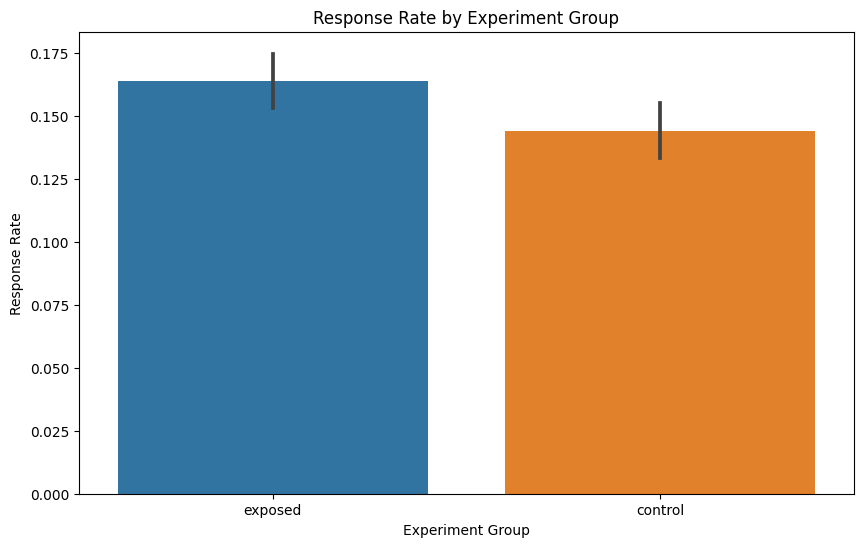

In [7]:
# Calculate the average response rate for each experiment group
response_by_exp = data.groupby('experiment')['response'].mean()
print("\nAverage response rate by experiment group:")
print(response_by_exp)

# Visualize the response rates
plt.figure(figsize=(10, 6))
sns.barplot(x='experiment', y='response', data=data)
plt.title('Response Rate by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Response Rate')
plt.show()



Average conversion rate by experiment group:
experiment
control    0.064849
exposed    0.076885
Name: conversion, dtype: float64


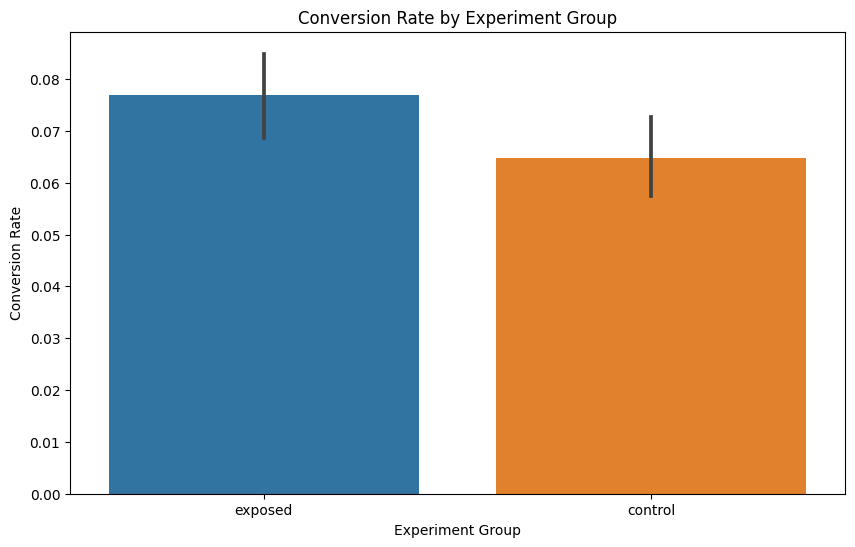

In [12]:
# Calculate the average conversion rate for each experiment group
conversion_by_exp = data.groupby('experiment')['conversion'].mean()
print("\nAverage conversion rate by experiment group:")
print(conversion_by_exp)

# Visualize the conversion rates
plt.figure(figsize=(10, 6))
sns.barplot(x='experiment', y='conversion', data=data)
plt.title('Conversion Rate by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Conversion Rate')
plt.show()


In [13]:
# Perform t-tests to check for statistical significance
control_response = data[data['experiment'] == 'control']['response']
exposed_response = data[data['experiment'] == 'exposed']['response']
t_stat_response, p_value_response = stats.ttest_ind(control_response, exposed_response)
print(f"Response Rate t-test: t-statistic: {t_stat_response}, p-value: {p_value_response}")

control_conversion = data[data['experiment'] == 'control']['conversion']
exposed_conversion = data[data['experiment'] == 'exposed']['conversion']
t_stat_conversion, p_value_conversion = stats.ttest_ind(control_conversion, exposed_conversion)
print(f"Conversion Rate t-test: t-statistic: {t_stat_conversion}, p-value: {p_value_conversion}")


Response Rate t-test: t-statistic: -2.4985134833114286, p-value: 0.012491258853514858
Conversion Rate t-test: t-statistic: -2.108610239127817, p-value: 0.035008955674483075


In [ ]:

# For response rate
bootstrap_response = bootstrap((control_response, exposed_response), 
                              statistic=lambda x, y: np.mean(y) - np.mean(x),
                              n_resamples=10000,
                              confidence_level=0.95)
print("\nBootstrap confidence interval for difference in response rates:")
print(f"95% CI: [{bootstrap_response.confidence_interval.low:.4f}, {bootstrap_response.confidence_interval.high:.4f}]")



Bootstrap confidence interval for difference in response rates:
95% CI: [0.0045, 0.0359]


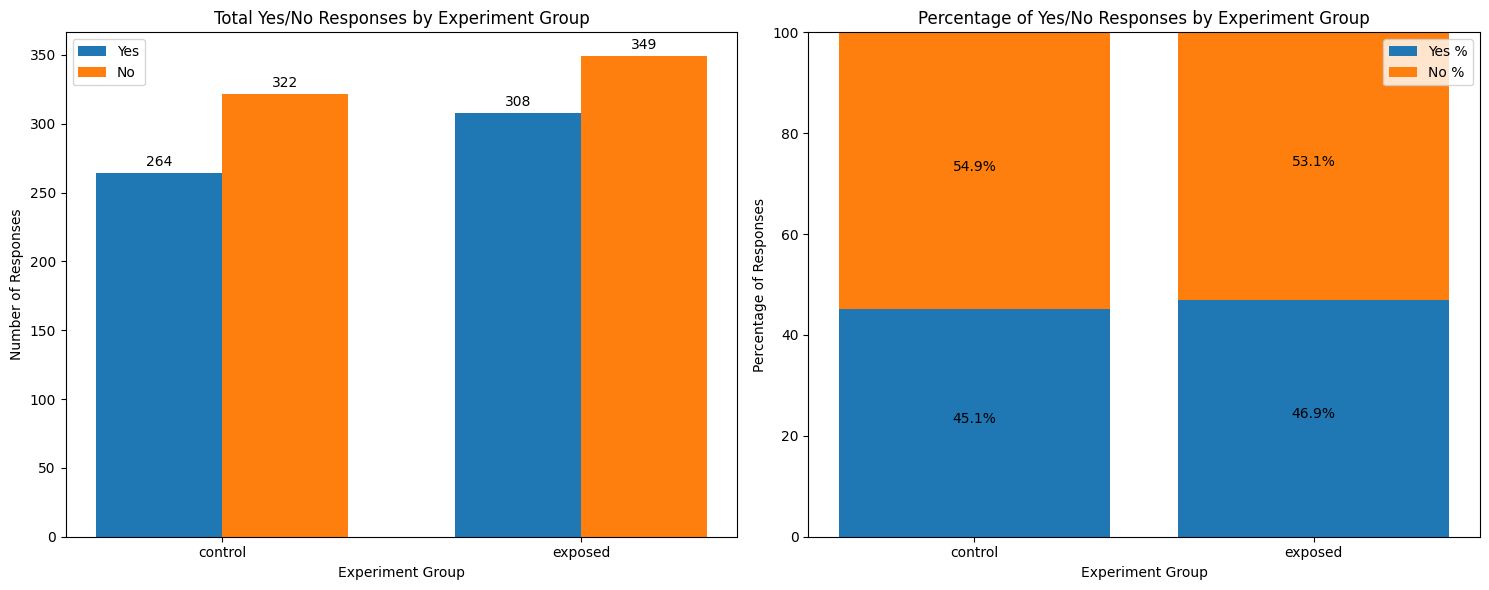

In [18]:
# Grouping by experiment and calculating total yes and no responses
response_totals = data.groupby('experiment')[['yes', 'no']].sum()
response_totals.reset_index(inplace=True)

# Calculate the total responses for each group
response_totals['total_responses'] = response_totals['yes'] + response_totals['no']

# Calculate percentages
response_totals['yes_percent'] = (response_totals['yes'] / response_totals['total_responses']) * 100
response_totals['no_percent'] = (response_totals['no'] / response_totals['total_responses']) * 100

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Bar chart for total values
x = np.arange(len(response_totals['experiment']))
width = 0.35

ax1.bar(x - width/2, response_totals['yes'], width, label='Yes')
ax1.bar(x + width/2, response_totals['no'], width, label='No')

ax1.set_xlabel('Experiment Group')
ax1.set_ylabel('Number of Responses')
ax1.set_title('Total Yes/No Responses by Experiment Group')
ax1.set_xticks(x)
ax1.set_xticklabels(response_totals['experiment'])
ax1.legend()

# Add value labels on top of bars
for i, v in enumerate(response_totals['yes']):
    ax1.text(i - width/2, v + 5, str(v), ha='center')
    
for i, v in enumerate(response_totals['no']):
    ax1.text(i + width/2, v + 5, str(v), ha='center')

# Plot 2: Stacked percentage bar chart
ax2.bar(response_totals['experiment'], response_totals['yes_percent'], label='Yes %')
ax2.bar(response_totals['experiment'], response_totals['no_percent'], 
        bottom=response_totals['yes_percent'], label='No %')

ax2.set_xlabel('Experiment Group')
ax2.set_ylabel('Percentage of Responses')
ax2.set_title('Percentage of Yes/No Responses by Experiment Group')
ax2.set_ylim(0, 100)
ax2.legend()

# Add percentage labels in the middle of each segment
for i, experiment in enumerate(response_totals['experiment']):
    # Yes percentages
    yes_pct = response_totals.loc[i, 'yes_percent']
    ax2.text(i, yes_pct/2, f'{yes_pct:.1f}%', ha='center')
    
    # No percentages
    no_pct = response_totals.loc[i, 'no_percent']
    ax2.text(i, yes_pct + no_pct/2, f'{no_pct:.1f}%', ha='center')

plt.tight_layout()
plt.show()

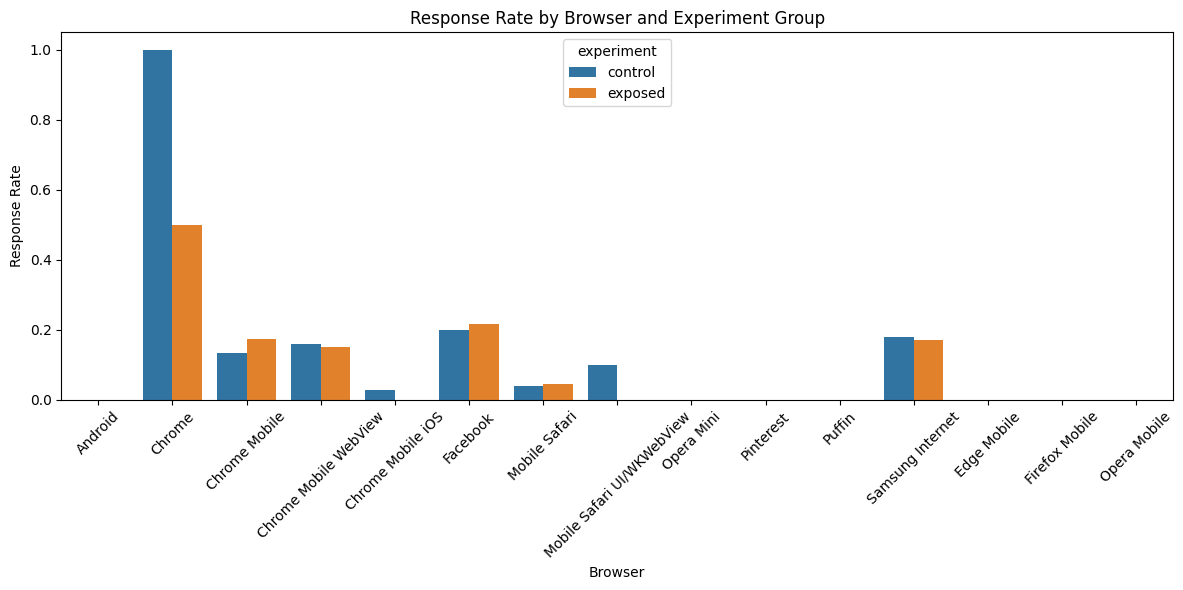

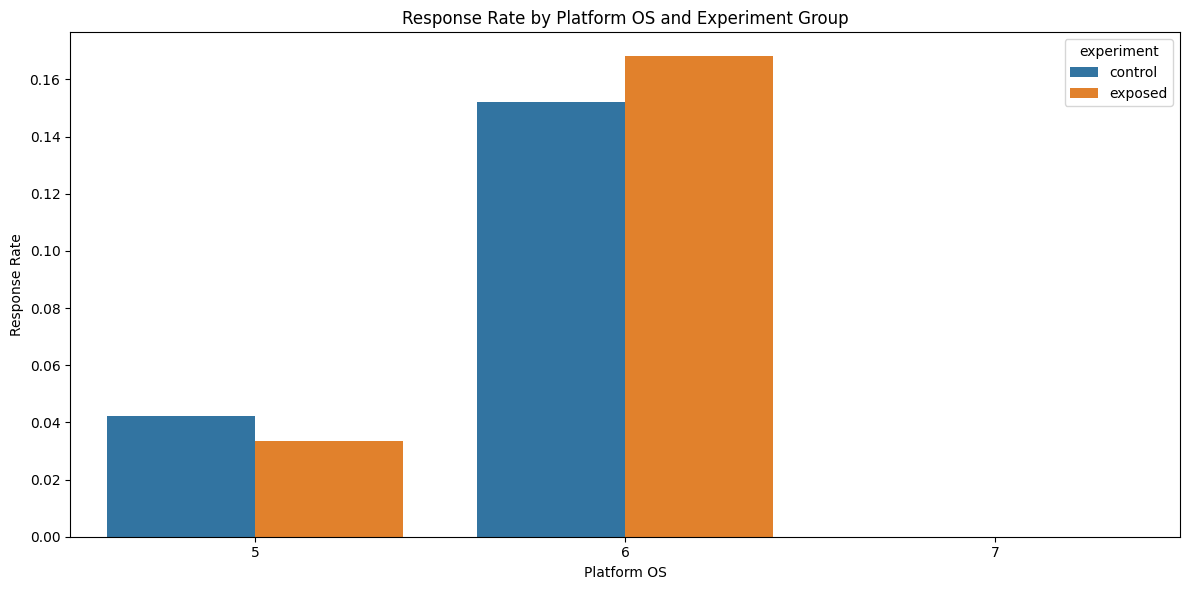

In [13]:
# Response rates by browser
browser_response = data.groupby(['experiment', 'browser'])['response'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='browser', y='response', hue='experiment', data=browser_response)
plt.title('Response Rate by Browser and Experiment Group')
plt.xlabel('Browser')
plt.ylabel('Response Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Response rates by platform_os
os_response = data.groupby(['experiment', 'platform_os'])['response'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='platform_os', y='response', hue='experiment', data=os_response)
plt.title('Response Rate by Platform OS and Experiment Group')
plt.xlabel('Platform OS')
plt.ylabel('Response Rate')
plt.tight_layout()
plt.show()


Bayesian A/B test: Probability that exposed is better than control: 0.7398


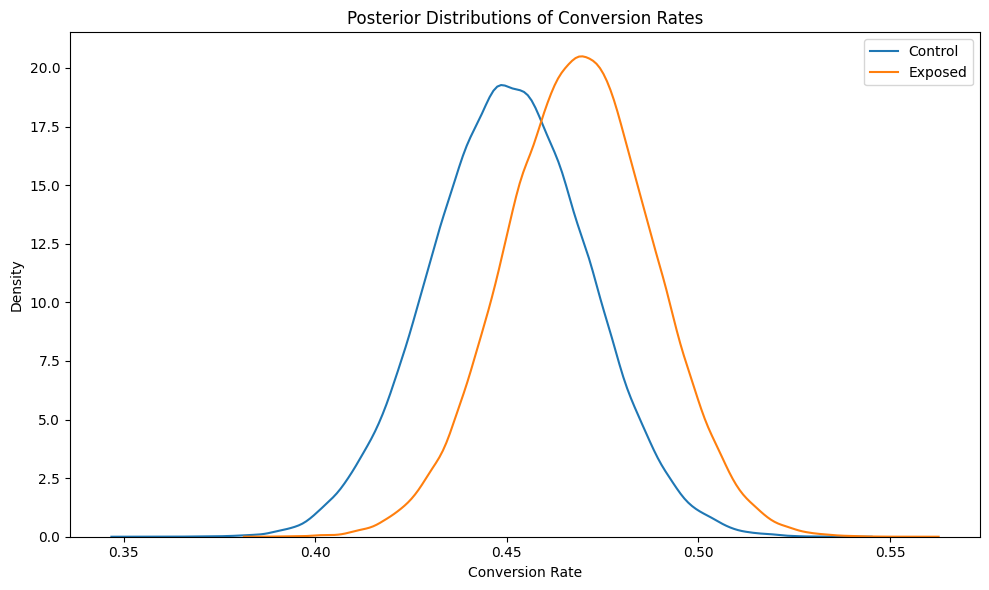

In [ ]:

# For conversion rates
control_conversions = data[data['experiment'] == 'control']['yes'].sum()
control_non_conversions = data[data['experiment'] == 'control']['response'].sum() - control_conversions

exposed_conversions = data[data['experiment'] == 'exposed']['yes'].sum()
exposed_non_conversions = data[data['experiment'] == 'exposed']['response'].sum() - exposed_conversions

# Prior parameters (assuming a weak Beta(1, 1) prior)
a_prior, b_prior = 1, 1

# Posterior parameters
a_control_posterior = a_prior + control_conversions
b_control_posterior = b_prior + control_non_conversions

a_exposed_posterior = a_prior + exposed_conversions
b_exposed_posterior = b_prior + exposed_non_conversions

# Generate samples from posterior distributions
n_samples = 100000
control_samples = beta.rvs(a_control_posterior, b_control_posterior, size=n_samples)
exposed_samples = beta.rvs(a_exposed_posterior, b_exposed_posterior, size=n_samples)

# Probability that exposed is better than control
prob_exposed_better = (exposed_samples > control_samples).mean()
print(f"Bayesian A/B test: Probability that exposed is better than control: {prob_exposed_better:.4f}")

# Plot posterior distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(control_samples, label='Control')
sns.kdeplot(exposed_samples, label='Exposed')
plt.title('Posterior Distributions of Conversion Rates')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In [42]:

def categorize_device_make(device):
    # Samsung devices
    if 'Samsung' in device:
        return 'Samsung'
    
    # Apple devices
    elif 'iPhone' in device:
        return 'Apple'
    
    # Google devices
    elif 'Pixel' in device or 'Nexus' in device:
        return 'Google'
    
    # Xiaomi devices (with various spellings)
    elif 'XiaoMi' in device or 'MI ' in device or 'MI MAX' in device:
        return 'Xiaomi'
    
    # HTC devices
    elif 'HTC' in device:
        return 'HTC'
    
    # OnePlus devices
    elif 'OnePlus' in device:
        return 'OnePlus'
    
    # Motorola devices
    elif 'Moto' in device or 'XT' in device:
        return 'Motorola'
    
    # Huawei devices
    elif 'HUAWEI' in device or 'Huawei' in device:
        return 'Huawei'
    
    # LG devices
    elif 'LG' in device:
        return 'LG'
    
    # Lenovo devices
    elif 'Lenovo' in device:
        return 'Lenovo'
    
    # Nokia devices
    elif 'Nokia' in device or 'Lumia' in device:
        return 'Nokia'
    
    # Asus devices
    elif 'Asus' in device:
        return 'Asus'
    
    # Vodafone devices
    elif 'Vodafone' in device or 'VFD' in device or 'VF-' in device:
        return 'Vodafone'
    
    # Generic smartphone
    elif 'Generic Smartphone' in device:
        return 'Generic'
    
    # Huawei model codes (based on pattern analysis)
    elif device.startswith(('ANE-', 'BKL-', 'BLA-', 'COR-', 'CLT-', 'DUB-', 'DUA-', 'DLI-', 
                           'ELE-', 'EVA-', 'EVR-', 'FIG-', 'FRD-', 'LYA-', 'LDN-', 'MAR-', 
                           'MHA-', 'MRD-', 'NEM-', 'POT-', 'PCT-', 'PRA-', 'RNE-', 'SNE-', 
                           'STF-', 'VCE-', 'VOG-', 'VTR-', 'VKY-', 'WAS-', 'YAL-')):
        return 'Huawei'
    
    # Sony model codes (based on pattern analysis)
    elif device.startswith(('C', 'D', 'E', 'F', 'G', 'H')) and re.match(r'^[A-Z]\d{4}$', device):
        return 'Sony'
    
    # BlackBerry model codes
    elif device.startswith(('BBB', 'BBF')):
        return 'BlackBerry'
    
    # Wileyfox devices
    elif 'Swift' in device or 'Wileyfox' in device:
        return 'Wileyfox'
    
    # For all other alphanumeric codes and unidentified models
    else:
        return 'various'

# Apply the function to create the new column
data['main_device_make'] = data['device_make'].apply(categorize_device_make)

# Display the distribution of main device categories
print(data['main_device_make'].value_counts())

Generic       4743
Samsung       2109
Apple          433
Huawei         296
Nokia          125
Google          79
various         61
OnePlus         60
LG              43
Sony            32
Xiaomi          28
Motorola        23
HTC             20
Vodafone        15
Lenovo           4
BlackBerry       3
Wileyfox         2
Asus             1
Name: main_device_make, dtype: int64


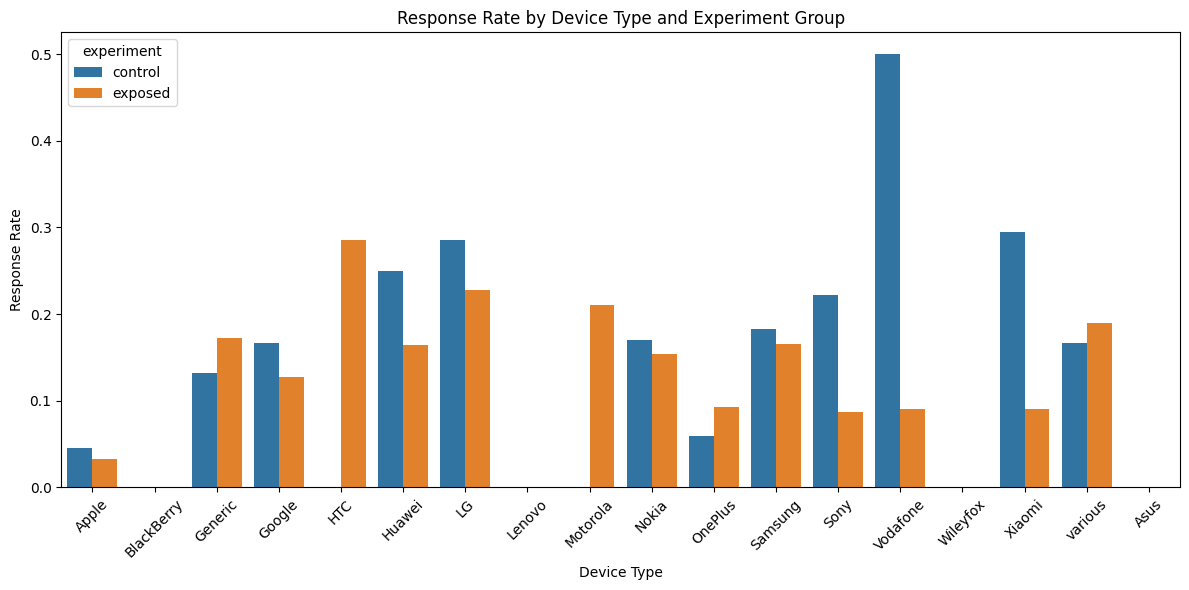

In [12]:
# Analyze response rates by device_make
device_response = data.groupby(['experiment', 'main_device_make'])['response'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='main_device_make', y='response', hue='experiment', data=device_response)
plt.title('Response Rate by Device Type and Experiment Group')
plt.xlabel('Device Type')
plt.ylabel('Response Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
#print(data.dtypes)  # Check column data types
#print(data.isnull().sum())  # Check for missing values

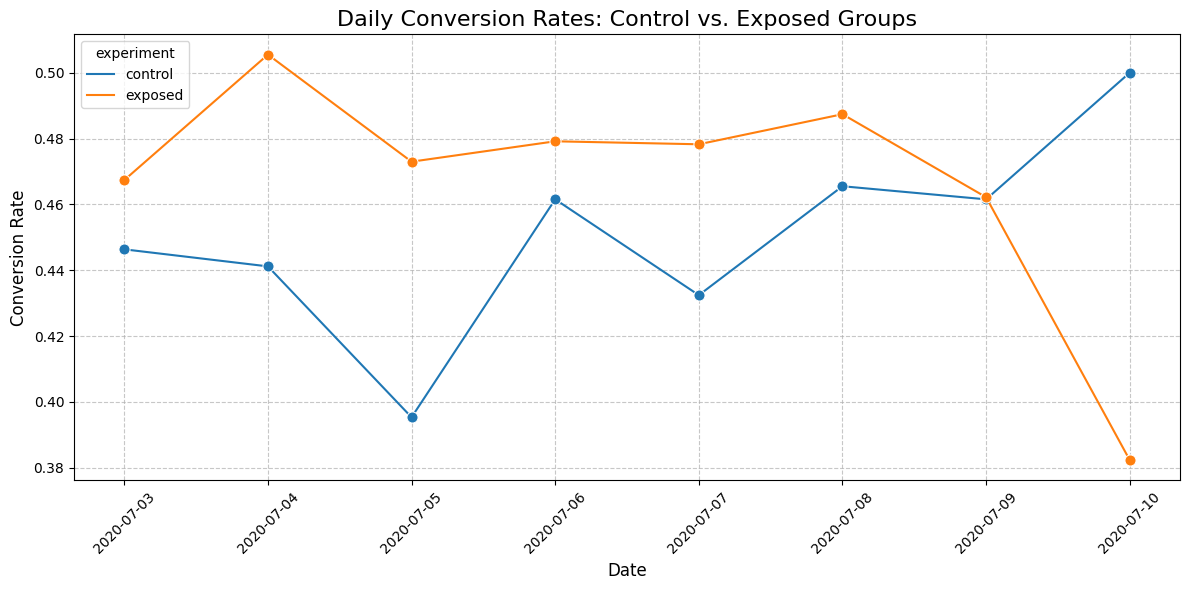

In [61]:
# Ensure date is datetime type
data['date'] = pd.to_datetime(data['date'])

# Convert yes and no columns to numeric types
data['yes'] = pd.to_numeric(data['yes'], errors='coerce')
data['no'] = pd.to_numeric(data['no'], errors='coerce')

# Calculate daily conversion rates
daily_conversions = data.groupby(['experiment', 'date'])[['yes', 'no']].sum()
daily_conversions['total_responses'] = daily_conversions['yes'] + daily_conversions['no']

# Safely calculate conversion rate
daily_conversions['conversion_rate'] = daily_conversions['yes'] / daily_conversions['total_responses']

# Reset index to make experiment and date regular columns
daily_conversions.reset_index(inplace=True)

# Handle any potential NaN or infinite values
daily_conversions['conversion_rate'] = daily_conversions['conversion_rate'].replace([np.inf, -np.inf], np.nan)
daily_conversions = daily_conversions.dropna(subset=['conversion_rate'])

# Create the visualization
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_conversions, 
    x='date', 
    y='conversion_rate', 
    hue='experiment', 
    marker='o',
    markersize=8,
    errorbar=None  # Disable error bars to avoid potential errors
)

# Customize the plot
plt.title('Daily Conversion Rates: Control vs. Exposed Groups', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


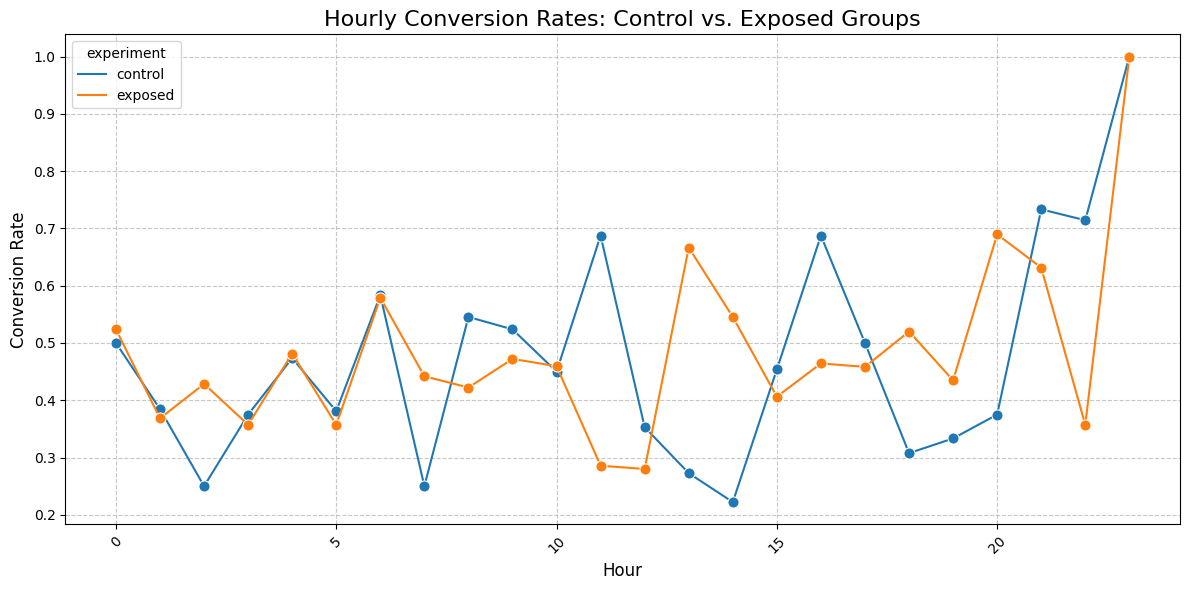

In [ ]:
# Convert yes and no columns to numeric types
data['yes'] = pd.to_numeric(data['yes'], errors='coerce')
data['no'] = pd.to_numeric(data['no'], errors='coerce')

# Calculate daily conversion rates
hourly_conversions = data.groupby(['experiment', 'hour'])[['yes', 'no']].sum()
hourly_conversions['total_responses'] = hourly_conversions['yes'] + hourly_conversions['no']

# Safely calculate conversion rate
hourly_conversions['conversion_rate'] = hourly_conversions['yes'] / hourly_conversions['total_responses']

# Reset index to make experiment and date regular columns
hourly_conversions.reset_index(inplace=True)

# Handle any potential NaN or infinite values
hourly_conversions['conversion_rate'] = hourly_conversions['conversion_rate'].replace([np.inf, -np.inf], np.nan)
hourly_conversions = hourly_conversions.dropna(subset=['conversion_rate'])

# Create the visualization
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_conversions, 
    x='hour', 
    y='conversion_rate', 
    hue='experiment', 
    marker='o',
    markersize=8,
    errorbar=None  # Disable error bars to avoid potential errors
)

# Customize the plot
plt.title('Hourly Conversion Rates: Control vs. Exposed Groups', fontsize=16)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
